## Modeling - Classifying Book Cover by Decade Published

In [1]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 3.1 MB/s 


In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import os

from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.tensorflow import balanced_batch_generator
from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

np.random.seed(42)

In [ ]:
!unzip /content/drive/MyDrive/datasets/capstone/images.zip

In [4]:
train = pd.read_csv('/content/drive/MyDrive/datasets/capstone/data/train_2_cleaned.csv', index_col=0)
test = pd.read_csv('/content/drive/MyDrive/datasets/capstone/data/test_2_cleaned.csv', index_col=0)

In [5]:
train.head(3)

,amazon_index,filename,title,author,category_id,category,meta,year,meta_author,decade
0,1588345297,1588345297.jpg,With Schwarzkopf: Life Lessons of The Bear,Gus Lee,1,Biographies & Memoirs,"{""ISBN-13"": ""9781588345295"", ""Title"": ""With Sc...",2015,Gus Lee,2010
1,1404803335,1404803335.jpg,"Magnets: Pulling Together, Pushing Apart (Amaz...",Natalie M. Rosinsky,4,Children's Books,"{""ISBN-13"": ""9781404803336"", ""Title"": ""Magnets...",2002,Natalie M. Rosinsky,2000
2,471310115,0471310115.jpg,"Janice VanCleave's 201 Awesome, Magical, Bizar...",Janice VanCleave,4,Children's Books,"{""ISBN-13"": ""9780471310112"", ""Title"": ""Janice ...",1994,Janice VanCleave,1990


In [6]:
test.head(3)

,amazon_index,filename,title,author,category_id,category,meta,year,meta_author,decade
0,60750715,0060750715.jpg,George Balanchine: The Ballet Maker (Eminent L...,Robert Gottlieb,1,Biographies & Memoirs,"{""ISBN-13"": ""9780060750701"", ""Title"": ""George ...",2004,Robert Gottlieb,2000
1,312556411,0312556411.jpg,Literature and Its Writers: A Compact Introduc...,Ann Charters,15,Literature & Fiction,"{""ISBN-13"": ""9781457606472"", ""Title"": ""Literat...",2012,Ann Charters,2010
2,545700272,0545700272.jpg,A Handful of Stars,Cynthia Lord,4,Children's Books,"{""ISBN-13"": ""9780545700283"", ""Title"": ""A Handf...",2017,Cynthia Lord,2010


In [7]:
train['decade'] = train['decade'].astype('str')

In [8]:
test['decade'] = test['decade'].astype('str')

### Baseline Model

In [ ]:
train['decade'].value_counts(normalize=True)

2010    0.585719
2000    0.251179
1990    0.126577
1980    0.026544
2020    0.009981
Name: decade, dtype: float64

In [ ]:
test['decade'].value_counts(normalize=True)

2010    0.591398
2000    0.258065
1990    0.123167
1980    0.021505
2020    0.005865
Name: decade, dtype: float64

#### Importing Images

In [9]:
datagen = ImageDataGenerator(rescale=1/255)

In [10]:
train_gen = datagen.flow_from_dataframe(
    dataframe=train,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(256,256)
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(256,256)
)

Found 9117 validated image filenames belonging to 5 classes.
Found 1023 validated image filenames belonging to 5 classes.


### First Model with 5 Categories

In [ ]:
model1 = Sequential()
model1.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64,(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(64,activation='relu'))
model1.add(Dense(5,activation='softmax'))

model1.compile(
    optimizer ='adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history1 = model1.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10
)

Epoch 1/10
285/285 [==============================] - 29s 100ms/step - loss: 1.1825 - accuracy: 0.5831 - val_loss: 1.0370 - val_accuracy: 0.5934
Epoch 2/10
285/285 [==============================] - 29s 101ms/step - loss: 0.9636 - accuracy: 0.6088 - val_loss: 0.9934 - val_accuracy: 0.6022
Epoch 3/10
285/285 [==============================] - 28s 98ms/step - loss: 0.7372 - accuracy: 0.6905 - val_loss: 1.1270 - val_accuracy: 0.6109
Epoch 4/10
285/285 [==============================] - 28s 99ms/step - loss: 0.4203 - accuracy: 0.8339 - val_loss: 1.3565 - val_accuracy: 0.5816
Epoch 5/10
285/285 [==============================] - 28s 99ms/step - loss: 0.1920 - accuracy: 0.9323 - val_loss: 2.0378 - val_accuracy: 0.6188
Epoch 6/10
285/285 [==============================] - 28s 99ms/step - loss: 0.1002 - accuracy: 0.9701 - val_loss: 2.8634 - val_accuracy: 0.6168
Epoch 7/10
285/285 [==============================] - 28s 99ms/step - loss: 0.0629 - accuracy: 0.9834 - val_loss: 2.9983 - val_accurac

In [ ]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(test_gen.samples / test_gen.batch_size)
preds = model1.predict(test_gen, steps=test_steps_per_epoch)

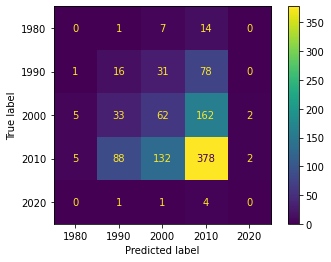

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_gen.classes, np.argmax(preds, axis=1), display_labels=list(test_gen.class_indices.keys()));

### Adding Additional Conv2D and MaxPooling 2D Layers with Dropout and Early Stopping

In [ ]:
model2 = Sequential()
model2.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(64,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(5,activation='softmax'))

model2.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
)

In [ ]:
 history2 = model2.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 43s 109ms/step - loss: 1.0944 - accuracy: 0.5785 - val_loss: 1.0244 - val_accuracy: 0.5914
Epoch 2/10
285/285 [==============================] - 29s 102ms/step - loss: 1.0603 - accuracy: 0.5813 - val_loss: 1.0172 - val_accuracy: 0.5914
Epoch 3/10
285/285 [==============================] - 29s 102ms/step - loss: 1.0444 - accuracy: 0.5853 - val_loss: 1.0372 - val_accuracy: 0.5806
Epoch 4/10
285/285 [==============================] - 29s 102ms/step - loss: 1.0301 - accuracy: 0.5870 - val_loss: 1.0014 - val_accuracy: 0.5924
Epoch 5/10
285/285 [==============================] - 29s 103ms/step - loss: 1.0132 - accuracy: 0.5904 - val_loss: 1.0029 - val_accuracy: 0.5865
Epoch 6/10
285/285 [==============================] - 29s 103ms/step - loss: 0.9867 - accuracy: 0.5999 - val_loss: 0.9967 - val_accuracy: 0.5855
Epoch 7/10
285/285 [==============================] - 30s 104ms/step - loss: 0.9570 - accuracy: 0.6084 - val_loss: 1.0072 - val_ac

In [ ]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(test_gen.samples / test_gen.batch_size)
preds = model2.predict(test_gen, steps=test_steps_per_epoch)

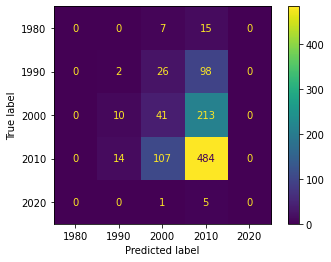

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_gen.classes, np.argmax(preds, axis=1), display_labels=list(test_gen.class_indices.keys()));

#### Adding Extra Conv2D and MaxPooling2D Layer

In [ ]:
model3 = Sequential()
model3.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())
model3.add(Dense(64,activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(5,activation='softmax'))

model3.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history3 = model3.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 30s 103ms/step - loss: 1.0735 - accuracy: 0.5809 - val_loss: 1.0301 - val_accuracy: 0.5914
Epoch 2/10
285/285 [==============================] - 29s 102ms/step - loss: 1.0356 - accuracy: 0.5825 - val_loss: 1.0151 - val_accuracy: 0.5924
Epoch 3/10
285/285 [==============================] - 29s 103ms/step - loss: 1.0012 - accuracy: 0.5922 - val_loss: 0.9955 - val_accuracy: 0.5894
Epoch 4/10
285/285 [==============================] - 29s 103ms/step - loss: 0.9534 - accuracy: 0.6063 - val_loss: 0.9812 - val_accuracy: 0.5767
Epoch 5/10
285/285 [==============================] - 29s 103ms/step - loss: 0.8892 - accuracy: 0.6290 - val_loss: 0.9997 - val_accuracy: 0.5855
Epoch 6/10
285/285 [==============================] - 30s 104ms/step - loss: 0.8056 - accuracy: 0.6644 - val_loss: 1.0141 - val_accuracy: 0.5826
Epoch 7/10
285/285 [==============================] - 30s 104ms/step - loss: 0.7155 - accuracy: 0.7063 - val_loss: 0.9805 - val_ac

In [ ]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(test_gen.samples / test_gen.batch_size)
preds = model3.predict(test_gen, steps=test_steps_per_epoch)

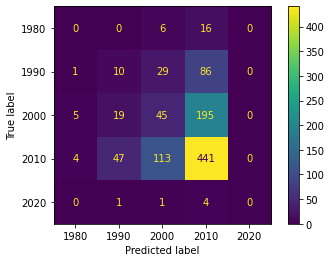

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_gen.classes, np.argmax(preds, axis=1), display_labels=list(test_gen.class_indices.keys()));

#### Changing neurons in layers

In [ ]:
model4 = Sequential()
model4.add(Conv2D(80,(3,3),activation='relu',input_shape=(256,256,3)))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(70,(3,3),activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(64,(3,3),activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Flatten())
model4.add(Dense(50,activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(5,activation='softmax'))

model4.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history4 = model4.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 42s 141ms/step - loss: 1.0847 - accuracy: 0.5812 - val_loss: 1.0236 - val_accuracy: 0.5914
Epoch 2/10
285/285 [==============================] - 39s 135ms/step - loss: 1.0469 - accuracy: 0.5845 - val_loss: 1.0130 - val_accuracy: 0.5914
Epoch 3/10
285/285 [==============================] - 38s 135ms/step - loss: 1.0111 - accuracy: 0.5911 - val_loss: 1.0337 - val_accuracy: 0.5924
Epoch 4/10
285/285 [==============================] - 39s 135ms/step - loss: 0.9613 - accuracy: 0.6003 - val_loss: 1.0004 - val_accuracy: 0.5963
Epoch 5/10
285/285 [==============================] - 39s 136ms/step - loss: 0.9020 - accuracy: 0.6248 - val_loss: 0.9987 - val_accuracy: 0.5875
Epoch 6/10
285/285 [==============================] - 39s 136ms/step - loss: 0.8166 - accuracy: 0.6528 - val_loss: 1.0283 - val_accuracy: 0.5787
Epoch 7/10
285/285 [==============================] - 39s 136ms/step - loss: 0.7374 - accuracy: 0.6894 - val_loss: 0.9816 - val_ac

In [ ]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(test_gen.samples / test_gen.batch_size)
preds = model4.predict(test_gen, steps=test_steps_per_epoch)

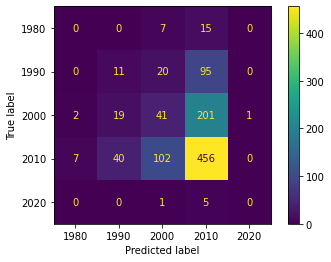

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_gen.classes, np.argmax(preds, axis=1), display_labels=list(test_gen.class_indices.keys()));

### Data Augmentation

In [ ]:
aug_train_gen = ImageDataGenerator(rescale=1/255, vertical_flip=True, rotation_range=20)
aug_test_gen = ImageDataGenerator(rescale=1/225, vertical_flip=True, rotation_range=20)

In [ ]:
aug_train = aug_train_gen.flow_from_dataframe(
    dataframe=train,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical'
)

aug_test = aug_test_gen.flow_from_dataframe(
    dataframe=test,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical'
)

Found 9117 validated image filenames belonging to 5 classes.
Found 1023 validated image filenames belonging to 5 classes.


In [ ]:
model5 = Sequential()
model5.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model5.add(MaxPool2D(pool_size=(2,2)))

model5.add(Flatten())
model5.add(Dense(units=100, activation='relu'))
model5.add(Dense(units=5, activation='softmax'))

model5.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history5 = model5.fit(
    aug_train,
    batch_size=32,
    validation_data=aug_test,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 134s 468ms/step - loss: 1.3456 - accuracy: 0.5267 - val_loss: 1.1161 - val_accuracy: 0.5083
Epoch 2/10
285/285 [==============================] - 133s 467ms/step - loss: 1.1202 - accuracy: 0.5662 - val_loss: 1.2249 - val_accuracy: 0.5914
Epoch 3/10
285/285 [==============================] - 132s 462ms/step - loss: 1.0655 - accuracy: 0.5767 - val_loss: 1.0842 - val_accuracy: 0.5894
Epoch 4/10
285/285 [==============================] - 133s 467ms/step - loss: 1.0550 - accuracy: 0.5795 - val_loss: 1.0268 - val_accuracy: 0.6012
Epoch 5/10
285/285 [==============================] - 132s 465ms/step - loss: 1.0332 - accuracy: 0.5905 - val_loss: 1.0258 - val_accuracy: 0.5973
Epoch 6/10
285/285 [==============================] - 132s 464ms/step - loss: 1.0247 - accuracy: 0.5960 - val_loss: 1.0498 - val_accuracy: 0.5455
Epoch 7/10
285/285 [==============================] - 134s 470ms/step - loss: 1.0173 - accuracy: 0.5970 - val_loss: 1.0293 -

In [ ]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(aug_test.samples / aug_test.batch_size)
preds = model5.predict(aug_test, steps=test_steps_per_epoch)

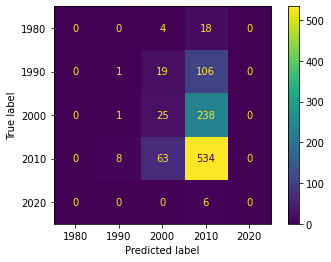

In [ ]:
ConfusionMatrixDisplay.from_predictions(aug_test.classes, np.argmax(preds, axis=1), display_labels=list(aug_test.class_indices.keys()));

#### Data Augmentation - Adding Additional Conv2D and MaxPool2D Layer

In [ ]:
model6 = Sequential()
model6.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model6.add(MaxPool2D(pool_size=(2,2)))

model6.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model6.add(MaxPool2D(pool_size=(2,2)))

model6.add(Flatten())
model6.add(Dense(units=100, activation='relu'))
model6.add(Dense(units=5, activation='softmax'))

model6.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history6 = model6.fit(
    aug_train,
    batch_size=32,
    validation_data=aug_test,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 144s 503ms/step - loss: 1.0936 - accuracy: 0.5758 - val_loss: 1.0748 - val_accuracy: 0.5914
Epoch 2/10
285/285 [==============================] - 139s 489ms/step - loss: 1.0449 - accuracy: 0.5877 - val_loss: 1.0282 - val_accuracy: 0.5953
Epoch 3/10
285/285 [==============================] - 141s 494ms/step - loss: 1.0420 - accuracy: 0.5836 - val_loss: 1.0461 - val_accuracy: 0.5914
Epoch 4/10
285/285 [==============================] - 140s 489ms/step - loss: 1.0157 - accuracy: 0.5930 - val_loss: 1.0235 - val_accuracy: 0.5953
Epoch 5/10
285/285 [==============================] - 141s 496ms/step - loss: 1.0084 - accuracy: 0.5949 - val_loss: 1.0178 - val_accuracy: 0.5865
Epoch 6/10
285/285 [==============================] - 140s 490ms/step - loss: 0.9913 - accuracy: 0.6017 - val_loss: 1.0145 - val_accuracy: 0.5904
Epoch 7/10
285/285 [==============================] - 140s 490ms/step - loss: 0.9814 - accuracy: 0.6058 - val_loss: 1.0325 -

In [ ]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(aug_test.samples / aug_test.batch_size)
preds = model6.predict(aug_test, steps=test_steps_per_epoch)

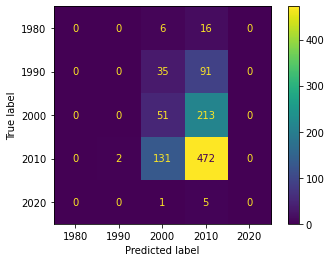

In [ ]:
ConfusionMatrixDisplay.from_predictions(aug_test.classes, np.argmax(preds, axis=1), display_labels=list(aug_test.class_indices.keys()));

In [ ]:
model7 = Sequential()
model7.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model7.add(MaxPool2D(pool_size=(2,2)))

model7.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model7.add(MaxPool2D(pool_size=(2,2)))

model7.add(Flatten())
model7.add(Dense(units=100, activation='relu'))
model7.add(Dense(units=5, activation='softmax'))

model7.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history7 = model7.fit(
    aug_train,
    batch_size=32,
    validation_data=aug_test,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 157s 548ms/step - loss: 1.2155 - accuracy: 0.5737 - val_loss: 1.1038 - val_accuracy: 0.5396
Epoch 2/10
285/285 [==============================] - 141s 495ms/step - loss: 1.0718 - accuracy: 0.5837 - val_loss: 1.0541 - val_accuracy: 0.5885
Epoch 3/10
285/285 [==============================] - 141s 496ms/step - loss: 1.0552 - accuracy: 0.5854 - val_loss: 1.0674 - val_accuracy: 0.5836
Epoch 4/10
285/285 [==============================] - 143s 502ms/step - loss: 1.0430 - accuracy: 0.5884 - val_loss: 1.0273 - val_accuracy: 0.5894
Epoch 5/10
285/285 [==============================] - 142s 497ms/step - loss: 1.0306 - accuracy: 0.5915 - val_loss: 1.0275 - val_accuracy: 0.5855
Epoch 6/10
285/285 [==============================] - 140s 490ms/step - loss: 1.0204 - accuracy: 0.5913 - val_loss: 1.0608 - val_accuracy: 0.5797
Epoch 7/10
285/285 [==============================] - 140s 492ms/step - loss: 1.0128 - accuracy: 0.5947 - val_loss: 1.0182 -

In [ ]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(aug_test.samples / aug_test.batch_size)
preds = model7.predict(aug_test, steps=test_steps_per_epoch)

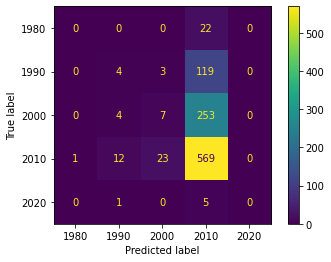

In [ ]:
ConfusionMatrixDisplay.from_predictions(aug_test.classes, np.argmax(preds, axis=1), display_labels=list(aug_test.class_indices.keys()));

In [ ]:
model8 = Sequential()
model8.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.001)))
model8.add(MaxPool2D(pool_size=(2,2)))

model8.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',kernel_regularizer=l2(0.001)))
model8.add(MaxPool2D(pool_size=(2,2)))

model8.add(Flatten())
model8.add(Dense(units=100, activation='relu', kernel_regularizer=l2(0.001)))
model8.add(Dense(units=5, activation='softmax', kernel_regularizer=l2(0.001)))

model8.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history8 = model8.fit(
    aug_train,
    batch_size=32,
    validation_data=aug_test,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 158s 551ms/step - loss: 1.5236 - accuracy: 0.5761 - val_loss: 1.1503 - val_accuracy: 0.5914
Epoch 2/10
285/285 [==============================] - 141s 494ms/step - loss: 1.1478 - accuracy: 0.5850 - val_loss: 1.0904 - val_accuracy: 0.5904
Epoch 3/10
285/285 [==============================] - 141s 496ms/step - loss: 1.1172 - accuracy: 0.5866 - val_loss: 1.0856 - val_accuracy: 0.5924
Epoch 4/10
285/285 [==============================] - 139s 488ms/step - loss: 1.1053 - accuracy: 0.5853 - val_loss: 1.0714 - val_accuracy: 0.5924
Epoch 5/10
285/285 [==============================] - 139s 488ms/step - loss: 1.1016 - accuracy: 0.5866 - val_loss: 1.0761 - val_accuracy: 0.5914
Epoch 6/10
285/285 [==============================] - 141s 493ms/step - loss: 1.1014 - accuracy: 0.5857 - val_loss: 1.0833 - val_accuracy: 0.5914
Epoch 7/10
285/285 [==============================] - 139s 488ms/step - loss: 1.0912 - accuracy: 0.5860 - val_loss: 1.0717 -

In [ ]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(aug_test.samples / aug_test.batch_size)
preds = model8.predict(aug_test, steps=test_steps_per_epoch)

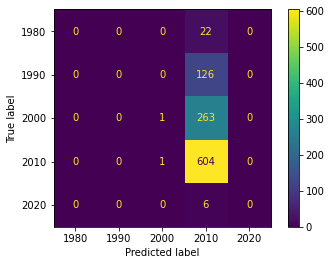

In [ ]:
ConfusionMatrixDisplay.from_predictions(aug_test.classes, np.argmax(preds, axis=1), display_labels=list(aug_test.class_indices.keys()));

#### EfficientNet

In [14]:
eff_train_gen = ImageDataGenerator(vertical_flip=True, rotation_range=20)
eff_test_gen = ImageDataGenerator(vertical_flip=True, rotation_range=20)

In [15]:
eff_aug_train = eff_train_gen.flow_from_dataframe(
    dataframe=train,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(224,224)
)

eff_aug_test = eff_test_gen.flow_from_dataframe(
    dataframe=test,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(224,224)
)

Found 9117 validated image filenames belonging to 5 classes.
Found 1023 validated image filenames belonging to 5 classes.


In [10]:
effnet = EfficientNetB0(include_top=False, weights='imagenet')

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
effnet.trainable = False

In [ ]:
model9 = Sequential()
model9.add(effnet)
model9.add(GlobalAveragePooling2D())
model9.add(Dense(64, activation='relu'))
model9.add(Dense(5, activation='softmax'))

model9.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history9 = model9.fit(
    eff_aug_train,
    batch_size=32,
    validation_data=eff_aug_test,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 122s 406ms/step - loss: 1.1186 - accuracy: 0.5545 - val_loss: 1.0258 - val_accuracy: 0.5865
Epoch 2/10
285/285 [==============================] - 113s 398ms/step - loss: 1.0131 - accuracy: 0.5911 - val_loss: 1.0050 - val_accuracy: 0.5894
Epoch 3/10
285/285 [==============================] - 114s 400ms/step - loss: 0.9852 - accuracy: 0.5994 - val_loss: 0.9946 - val_accuracy: 0.5894
Epoch 4/10
285/285 [==============================] - 115s 402ms/step - loss: 0.9616 - accuracy: 0.6117 - val_loss: 0.9904 - val_accuracy: 0.5953
Epoch 5/10
285/285 [==============================] - 113s 395ms/step - loss: 0.9502 - accuracy: 0.6149 - val_loss: 0.9839 - val_accuracy: 0.5865
Epoch 6/10
285/285 [==============================] - 113s 397ms/step - loss: 0.9346 - accuracy: 0.6227 - val_loss: 0.9878 - val_accuracy: 0.5982
Epoch 7/10
285/285 [==============================] - 114s 399ms/step - loss: 0.9222 - accuracy: 0.6264 - val_loss: 0.9798 -

In [ ]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(eff_aug_test.samples / eff_aug_test.batch_size)
preds = model9.predict(eff_aug_test, steps=test_steps_per_epoch)

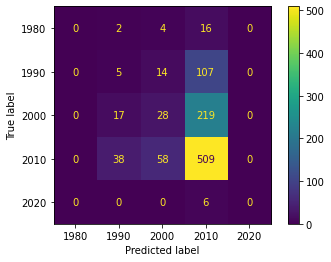

In [ ]:
ConfusionMatrixDisplay.from_predictions(eff_aug_test.classes, np.argmax(preds, axis=1), display_labels=list(eff_aug_test.class_indices.keys()));

#### EffNet with Class Weights

In [16]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory/67678399#67678399

class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(eff_aug_train.classes), 
            y = eff_aug_train.classes)

train_class_weights = dict(enumerate(class_weights))

In [24]:
model10 = Sequential()
model10.add(effnet)
model10.add(GlobalAveragePooling2D())
model10.add(Dense(64, activation='relu'))
model10.add(Dense(5, activation='softmax'))

model10.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

In [25]:
history10 = model10.fit(
    eff_aug_train,
    class_weight=train_class_weights,
    batch_size=32,
    validation_data=eff_aug_test,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 123s 413ms/step - loss: 1.6098 - accuracy: 0.2332 - val_loss: 1.5906 - val_accuracy: 0.2463
Epoch 2/100
285/285 [==============================] - 115s 404ms/step - loss: 1.5009 - accuracy: 0.2732 - val_loss: 1.5221 - val_accuracy: 0.3089
Epoch 3/100
285/285 [==============================] - 115s 405ms/step - loss: 1.4460 - accuracy: 0.3100 - val_loss: 1.5543 - val_accuracy: 0.2933
Epoch 4/100
285/285 [==============================] - 115s 404ms/step - loss: 1.3921 - accuracy: 0.3342 - val_loss: 1.4721 - val_accuracy: 0.3451
Epoch 5/100
285/285 [==============================] - 116s 408ms/step - loss: 1.3352 - accuracy: 0.3601 - val_loss: 1.5556 - val_accuracy: 0.2776
Epoch 6/100
285/285 [==============================] - 116s 406ms/step - loss: 1.2995 - accuracy: 0.3749 - val_loss: 1.5301 - val_accuracy: 0.3011
Epoch 7/100
285/285 [==============================] - 122s 428ms/step - loss: 1.2728 - accuracy: 0.3759 - val_loss: 1

In [26]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(eff_aug_test.samples / eff_aug_test.batch_size)
preds = model10.predict(eff_aug_test, steps=test_steps_per_epoch)

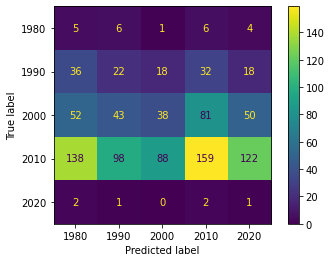

In [27]:
ConfusionMatrixDisplay.from_predictions(eff_aug_test.classes, np.argmax(preds, axis=1), display_labels=list(eff_aug_test.class_indices.keys()));

##### EffNet with Class Weights - Changing Learning Rate

In [13]:
model12 = Sequential()
model12.add(effnet)
model12.add(GlobalAveragePooling2D())
model12.add(Dense(64, activation='relu'))
model12.add(Dense(5, activation='softmax'))

model12.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

In [16]:
history12 = model12.fit(
    eff_aug_train,
    class_weight=train_class_weights,
    batch_size=32,
    validation_data=eff_aug_test,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 143s 447ms/step - loss: 1.5434 - accuracy: 0.2748 - val_loss: 1.5089 - val_accuracy: 0.2923
Epoch 2/10
285/285 [==============================] - 125s 437ms/step - loss: 1.3650 - accuracy: 0.3458 - val_loss: 1.5611 - val_accuracy: 0.2698
Epoch 3/10
285/285 [==============================] - 121s 423ms/step - loss: 1.2441 - accuracy: 0.3905 - val_loss: 1.5753 - val_accuracy: 0.3001
Epoch 4/10
285/285 [==============================] - 120s 420ms/step - loss: 1.1414 - accuracy: 0.4226 - val_loss: 1.5504 - val_accuracy: 0.3167
Epoch 5/10
285/285 [==============================] - 117s 412ms/step - loss: 1.0518 - accuracy: 0.4521 - val_loss: 1.3468 - val_accuracy: 0.3871
Epoch 6/10
285/285 [==============================] - 121s 426ms/step - loss: 0.9672 - accuracy: 0.4778 - val_loss: 1.2475 - val_accuracy: 0.4399
Epoch 7/10
285/285 [==============================] - 119s 417ms/step - loss: 0.8989 - accuracy: 0.5042 - val_loss: 1.1951 -

In [21]:
history12_2 = model12.fit(
    eff_aug_train,
    class_weight=train_class_weights,
    batch_size=32,
    validation_data=eff_aug_test,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 122s 428ms/step - loss: 0.7174 - accuracy: 0.5689 - val_loss: 1.2066 - val_accuracy: 0.4731
Epoch 2/100
285/285 [==============================] - 122s 427ms/step - loss: 0.7115 - accuracy: 0.5810 - val_loss: 1.4485 - val_accuracy: 0.3939
Epoch 3/100
285/285 [==============================] - 119s 419ms/step - loss: 0.6840 - accuracy: 0.5918 - val_loss: 1.2321 - val_accuracy: 0.4487
Epoch 4/100
285/285 [==============================] - 120s 422ms/step - loss: 0.6610 - accuracy: 0.5979 - val_loss: 1.2556 - val_accuracy: 0.4585
Epoch 5/100
285/285 [==============================] - 120s 422ms/step - loss: 0.6192 - accuracy: 0.6137 - val_loss: 1.1772 - val_accuracy: 0.5005
Epoch 6/100
285/285 [==============================] - 118s 413ms/step - loss: 0.6086 - accuracy: 0.6086 - val_loss: 1.3120 - val_accuracy: 0.4643
Epoch 7/100
285/285 [==============================] - 119s 416ms/step - loss: 0.5778 - accuracy: 0.6265 - val_loss: 1

In [22]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(eff_aug_test.samples / eff_aug_test.batch_size)
preds = model12.predict(eff_aug_test, steps=test_steps_per_epoch)

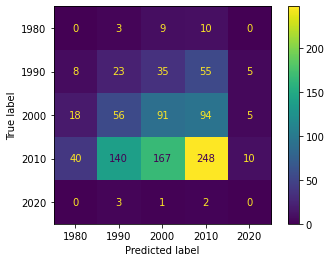

In [23]:
ConfusionMatrixDisplay.from_predictions(eff_aug_test.classes, np.argmax(preds, axis=1), display_labels=list(eff_aug_test.class_indices.keys()));

#### EffNet with Class Rates - Changing Dense Layer Nodes

In [28]:
model13 = Sequential()
model13.add(effnet)
model13.add(GlobalAveragePooling2D())
model13.add(Dense(128, activation='relu'))
model13.add(Dense(5, activation='softmax'))

model13.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

In [29]:
history13 = model13.fit(
    eff_aug_train,
    class_weight=train_class_weights,
    batch_size=32,
    validation_data=eff_aug_test,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 125s 417ms/step - loss: 1.5854 - accuracy: 0.2451 - val_loss: 1.5749 - val_accuracy: 0.2669
Epoch 2/100
285/285 [==============================] - 117s 410ms/step - loss: 1.4573 - accuracy: 0.3176 - val_loss: 1.6290 - val_accuracy: 0.2043
Epoch 3/100
285/285 [==============================] - 116s 408ms/step - loss: 1.3832 - accuracy: 0.3302 - val_loss: 1.5918 - val_accuracy: 0.2502
Epoch 4/100
285/285 [==============================] - 119s 418ms/step - loss: 1.3299 - accuracy: 0.3598 - val_loss: 1.5218 - val_accuracy: 0.3099
Epoch 5/100
285/285 [==============================] - 120s 420ms/step - loss: 1.2700 - accuracy: 0.3826 - val_loss: 1.4374 - val_accuracy: 0.3558
Epoch 6/100
285/285 [==============================] - 117s 410ms/step - loss: 1.2297 - accuracy: 0.4042 - val_loss: 1.4868 - val_accuracy: 0.3324
Epoch 7/100
285/285 [==============================] - 117s 410ms/step - loss: 1.2024 - accuracy: 0.4073 - val_loss: 1

In [30]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(eff_aug_test.samples / eff_aug_test.batch_size)
preds = model13.predict(eff_aug_test, steps=test_steps_per_epoch)

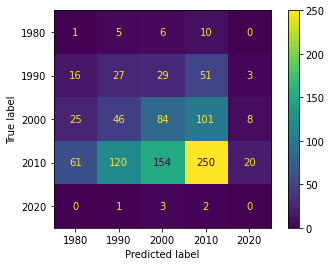

In [31]:
ConfusionMatrixDisplay.from_predictions(eff_aug_test.classes, np.argmax(preds, axis=1), display_labels=list(eff_aug_test.class_indices.keys()));

### Basic CNN with Weighted Classes

In [17]:
datagen_2 = ImageDataGenerator(rescale=1/255)

In [18]:
train_gen_2 = datagen_2.flow_from_dataframe(
    dataframe=train,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(256,256)
)

test_gen_2 = datagen_2.flow_from_dataframe(
    dataframe=test,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(256,256)
)

Found 9117 validated image filenames belonging to 5 classes.
Found 1023 validated image filenames belonging to 5 classes.


In [19]:
model11 = Sequential()
model11.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model11.add(MaxPooling2D(pool_size=(2,2)))

model11.add(Conv2D(64,(3,3),activation='relu'))
model11.add(MaxPooling2D(pool_size=(2,2)))

model11.add(Conv2D(64,(3,3),activation='relu'))
model11.add(MaxPooling2D(pool_size=(2,2)))

model11.add(Conv2D(64,(3,3),activation='relu'))
model11.add(MaxPooling2D(pool_size=(2,2)))

model11.add(Flatten())
model11.add(Dense(64,activation='relu'))
model11.add(Dropout(0.2))
model11.add(Dense(5,activation='softmax'))

model11.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [21]:
 history11 = model11.fit(
    train_gen_2,
    class_weight=train_class_weights,
    validation_data=test_gen_2,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 29s 101ms/step - loss: 1.4023 - accuracy: 0.2762 - val_loss: 1.4567 - val_accuracy: 0.2698
Epoch 2/100
285/285 [==============================] - 30s 106ms/step - loss: 1.3303 - accuracy: 0.3123 - val_loss: 1.4578 - val_accuracy: 0.3157
Epoch 3/100
285/285 [==============================] - 27s 93ms/step - loss: 1.2134 - accuracy: 0.3476 - val_loss: 1.5332 - val_accuracy: 0.2317
Epoch 4/100
285/285 [==============================] - 26s 92ms/step - loss: 1.0991 - accuracy: 0.3842 - val_loss: 1.3928 - val_accuracy: 0.3353
Epoch 5/100
285/285 [==============================] - 26s 92ms/step - loss: 1.0207 - accuracy: 0.4187 - val_loss: 1.3902 - val_accuracy: 0.3431
Epoch 6/100
285/285 [==============================] - 26s 93ms/step - loss: 0.9079 - accuracy: 0.4507 - val_loss: 1.2988 - val_accuracy: 0.3695
Epoch 7/100
285/285 [==============================] - 26s 92ms/step - loss: 0.8213 - accuracy: 0.4982 - val_loss: 1.2610 - val_

In [22]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(test_gen_2.samples / test_gen_2.batch_size)
preds = model11.predict(test_gen_2, steps=test_steps_per_epoch)

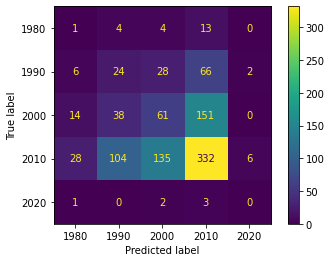

In [23]:
ConfusionMatrixDisplay.from_predictions(test_gen_2.classes, np.argmax(preds, axis=1), display_labels=list(test_gen_2.class_indices.keys()));

#### CNN with Weighted Classes, Altering Parameters

In [24]:
model14 = Sequential()
model14.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model14.add(MaxPooling2D(pool_size=(2,2)))

model14.add(Conv2D(64,(3,3),activation='relu'))
model14.add(MaxPooling2D(pool_size=(2,2)))

model14.add(Conv2D(64,(3,3),activation='relu'))
model14.add(MaxPooling2D(pool_size=(2,2)))

model14.add(Conv2D(64,(3,3),activation='relu'))
model14.add(MaxPooling2D(pool_size=(2,2)))

model14.add(Flatten())
model14.add(Dense(128,activation='relu'))
model14.add(Dropout(0.5))
model14.add(Dense(5,activation='softmax'))

model14.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [25]:
 history14 = model14.fit(
    train_gen_2,
    class_weight=train_class_weights,
    validation_data=test_gen_2,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 27s 94ms/step - loss: 1.6133 - accuracy: 0.2419 - val_loss: 1.5415 - val_accuracy: 0.3685
Epoch 2/100
285/285 [==============================] - 26s 91ms/step - loss: 1.5983 - accuracy: 0.2236 - val_loss: 1.5863 - val_accuracy: 0.0743
Epoch 3/100
285/285 [==============================] - 26s 91ms/step - loss: 1.5862 - accuracy: 0.2451 - val_loss: 1.6424 - val_accuracy: 0.0850
Epoch 4/100
285/285 [==============================] - 26s 91ms/step - loss: 1.5538 - accuracy: 0.2322 - val_loss: 1.5444 - val_accuracy: 0.2825
Epoch 5/100
285/285 [==============================] - 26s 90ms/step - loss: 1.5471 - accuracy: 0.2100 - val_loss: 1.5564 - val_accuracy: 0.1623
Epoch 6/100
285/285 [==============================] - 26s 93ms/step - loss: 1.4935 - accuracy: 0.2367 - val_loss: 1.4884 - val_accuracy: 0.2923
Epoch 7/100
285/285 [==============================] - 25s 89ms/step - loss: 1.4429 - accuracy: 0.2763 - val_loss: 1.5479 - val_ac

In [26]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(test_gen_2.samples / test_gen_2.batch_size)
preds = model14.predict(test_gen_2, steps=test_steps_per_epoch)

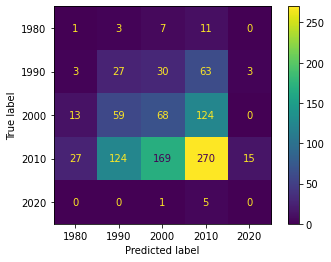

In [27]:
ConfusionMatrixDisplay.from_predictions(test_gen_2.classes, np.argmax(preds, axis=1), display_labels=list(test_gen_2.class_indices.keys()));

In [28]:
model15 = Sequential()
model15.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
model15.add(MaxPooling2D(pool_size=(2,2)))

model15.add(Conv2D(32,(3,3),activation='relu'))
model15.add(MaxPooling2D(pool_size=(2,2)))

model15.add(Conv2D(64,(3,3),activation='relu'))
model15.add(MaxPooling2D(pool_size=(2,2)))

model15.add(Conv2D(64,(3,3),activation='relu'))
model15.add(MaxPooling2D(pool_size=(2,2)))

model15.add(Conv2D(128,(3,3),activation='relu'))
model15.add(MaxPooling2D(pool_size=(2,2)))

model15.add(Flatten())
model15.add(Dense(128,activation='relu'))
model15.add(Dropout(0.4))
model15.add(Dense(5,activation='softmax'))

model15.compile(
    optimizer = Adam(learning_rate=.00001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [29]:
history15 = model15.fit(
    train_gen_2,
    class_weight=train_class_weights,
    validation_data=test_gen_2,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 28s 94ms/step - loss: 1.6113 - accuracy: 0.2676 - val_loss: 1.5955 - val_accuracy: 0.4448
Epoch 2/100
285/285 [==============================] - 25s 87ms/step - loss: 1.6029 - accuracy: 0.2391 - val_loss: 1.5861 - val_accuracy: 0.5034
Epoch 3/100
285/285 [==============================] - 25s 89ms/step - loss: 1.5997 - accuracy: 0.2343 - val_loss: 1.5937 - val_accuracy: 0.1896
Epoch 4/100
285/285 [==============================] - 25s 88ms/step - loss: 1.5939 - accuracy: 0.2378 - val_loss: 1.5860 - val_accuracy: 0.2903
Epoch 5/100
285/285 [==============================] - 25s 87ms/step - loss: 1.5912 - accuracy: 0.2879 - val_loss: 1.6067 - val_accuracy: 0.0890
Epoch 6/100
285/285 [==============================] - 25s 86ms/step - loss: 1.5790 - accuracy: 0.2299 - val_loss: 1.5937 - val_accuracy: 0.1779
Epoch 7/100
285/285 [==============================] - 25s 86ms/step - loss: 1.5695 - accuracy: 0.1996 - val_loss: 1.5880 - val_ac

In [31]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(test_gen_2.samples / test_gen_2.batch_size)
preds = model15.predict(test_gen_2, steps=test_steps_per_epoch)

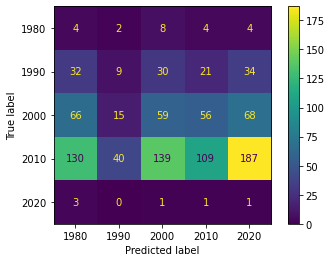

In [32]:
ConfusionMatrixDisplay.from_predictions(test_gen_2.classes, np.argmax(preds, axis=1), display_labels=list(test_gen_2.class_indices.keys()));

In [30]:
model16 = Sequential()
model16.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
model16.add(MaxPooling2D(pool_size=(2,2)))

model16.add(Conv2D(64,(3,3),activation='relu'))
model16.add(MaxPooling2D(pool_size=(2,2)))

model16.add(Flatten())
model16.add(Dense(128,activation='relu'))
model16.add(Dropout(0.4))
model16.add(Dense(5,activation='softmax'))

model16.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [33]:
history16 = model16.fit(
    train_gen_2,
    class_weight=train_class_weights,
    validation_data=test_gen_2,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 26s 88ms/step - loss: 1.8062 - accuracy: 0.2462 - val_loss: 1.5713 - val_accuracy: 0.2346
Epoch 2/100
285/285 [==============================] - 26s 91ms/step - loss: 1.5514 - accuracy: 0.2647 - val_loss: 1.5217 - val_accuracy: 0.4057
Epoch 3/100
285/285 [==============================] - 25s 87ms/step - loss: 1.4507 - accuracy: 0.2908 - val_loss: 1.5646 - val_accuracy: 0.2893
Epoch 4/100
285/285 [==============================] - 25s 88ms/step - loss: 1.3267 - accuracy: 0.3325 - val_loss: 1.5542 - val_accuracy: 0.2395
Epoch 5/100
285/285 [==============================] - 25s 88ms/step - loss: 1.1629 - accuracy: 0.3933 - val_loss: 1.4958 - val_accuracy: 0.2942
Epoch 6/100
285/285 [==============================] - 25s 89ms/step - loss: 1.0414 - accuracy: 0.4399 - val_loss: 1.2343 - val_accuracy: 0.5161
Epoch 7/100
285/285 [==============================] - 26s 91ms/step - loss: 0.9041 - accuracy: 0.4979 - val_loss: 1.1802 - val_ac

In [34]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(test_gen_2.samples / test_gen_2.batch_size)
preds = model16.predict(test_gen_2, steps=test_steps_per_epoch)

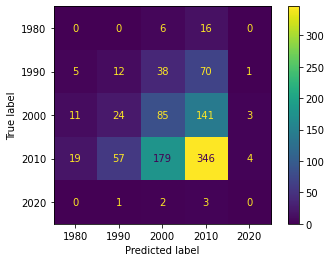

In [35]:
ConfusionMatrixDisplay.from_predictions(test_gen_2.classes, np.argmax(preds, axis=1), display_labels=list(test_gen_2.class_indices.keys()));

In [36]:
model17 = Sequential()

model17.add(Conv2D(64,(3,3),activation='relu'))
model17.add(MaxPooling2D(pool_size=(2,2)))

model17.add(Flatten())
model17.add(Dense(64,activation='relu'))
model17.add(Dropout(0.4))
model17.add(Dense(5,activation='softmax'))

model17.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [37]:
history17 = model17.fit(
    train_gen_2,
    class_weight=train_class_weights,
    validation_data=test_gen_2,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 29s 101ms/step - loss: 1.8774 - accuracy: 0.1600 - val_loss: 1.6094 - val_accuracy: 0.2581
Epoch 2/100
285/285 [==============================] - 27s 94ms/step - loss: 1.6095 - accuracy: 0.1414 - val_loss: 1.6095 - val_accuracy: 0.2581
Epoch 3/100
285/285 [==============================] - 26s 93ms/step - loss: 1.6041 - accuracy: 0.1373 - val_loss: 1.6092 - val_accuracy: 0.2581
Epoch 4/100
285/285 [==============================] - 27s 93ms/step - loss: 1.6056 - accuracy: 0.0945 - val_loss: 1.6094 - val_accuracy: 0.2581
Epoch 5/100
285/285 [==============================] - 27s 93ms/step - loss: 1.6024 - accuracy: 0.1644 - val_loss: 1.6093 - val_accuracy: 0.2581
Epoch 6/100
285/285 [==============================] - 27s 94ms/step - loss: 1.6060 - accuracy: 0.1438 - val_loss: 1.6090 - val_accuracy: 0.2581
Epoch 7/100
285/285 [==============================] - 27s 94ms/step - loss: 1.6053 - accuracy: 0.1926 - val_loss: 1.6089 - val_a

In [38]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(test_gen_2.samples / test_gen_2.batch_size)
preds = model17.predict(test_gen_2, steps=test_steps_per_epoch)

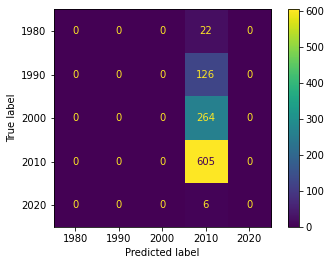

In [39]:
ConfusionMatrixDisplay.from_predictions(test_gen_2.classes, np.argmax(preds, axis=1), display_labels=list(test_gen_2.class_indices.keys()));

### Data Augmentation with Weighted Classes

In [40]:
aug_train_gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)

datagen = ImageDataGenerator(rescale=1/255)

In [41]:
aug_train = aug_train_gen.flow_from_dataframe(
    dataframe=train,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(256,256)
)

aug_test = datagen.flow_from_dataframe(
    dataframe=test,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(256,256)
)

Found 9117 validated image filenames belonging to 5 classes.
Found 1023 validated image filenames belonging to 5 classes.


In [42]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory/67678399#67678399

class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(aug_train.classes), 
            y = aug_train.classes)

train_class_weights = dict(enumerate(class_weights))

In [43]:
model18 = Sequential()
model18.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
model18.add(MaxPooling2D(pool_size=(2,2)))

model18.add(Conv2D(64,(3,3),activation='relu'))
model18.add(MaxPooling2D(pool_size=(2,2)))

model18.add(Flatten())
model18.add(Dense(128,activation='relu'))
model18.add(Dropout(0.4))
model18.add(Dense(5,activation='softmax'))

model18.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [44]:
history18 = model18.fit(
    aug_train,
    class_weight=train_class_weights,
    validation_data=aug_test,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 131s 458ms/step - loss: 1.6787 - accuracy: 0.1282 - val_loss: 1.6102 - val_accuracy: 0.1232
Epoch 2/100
285/285 [==============================] - 130s 456ms/step - loss: 1.6095 - accuracy: 0.1266 - val_loss: 1.6100 - val_accuracy: 0.1232
Epoch 3/100
285/285 [==============================] - 132s 461ms/step - loss: 1.6181 - accuracy: 0.1352 - val_loss: 1.6104 - val_accuracy: 0.1232
Epoch 4/100
285/285 [==============================] - 130s 455ms/step - loss: 1.6095 - accuracy: 0.1062 - val_loss: 1.6104 - val_accuracy: 0.1232
Epoch 5/100
285/285 [==============================] - 131s 461ms/step - loss: 1.6095 - accuracy: 0.0961 - val_loss: 1.6103 - val_accuracy: 0.1232
Epoch 6/100
285/285 [==============================] - 130s 456ms/step - loss: 1.6116 - accuracy: 0.0772 - val_loss: 1.6105 - val_accuracy: 0.1232
Epoch 7/100
285/285 [==============================] - 132s 462ms/step - loss: 1.6095 - accuracy: 0.0928 - val_loss: 1

In [45]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(aug_test.samples / aug_test.batch_size)
preds = model18.predict(aug_test, steps=test_steps_per_epoch)

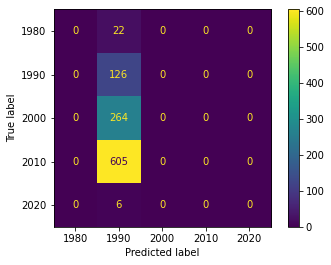

In [46]:
ConfusionMatrixDisplay.from_predictions(aug_test.classes, np.argmax(preds, axis=1), display_labels=list(aug_test.class_indices.keys()));

#### Hyperparameter Tuning with CNN & Weighted Classes

In [52]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory/67678399#67678399

class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(train_gen_2.classes), 
            y = train_gen_2.classes)

train_class_weights = dict(enumerate(class_weights))

In [48]:
# https://www.kaggle.com/code/arezoodahesh/fashion-mnist-cnn-model

def build_model(hp):
    model = Sequential([
        
    # First conv_block
    Conv2D(
        filters = hp.Choice('conv_1_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,4]),
        activation='relu',
        input_shape=(256,256,3)),
    MaxPooling2D((2,2)),
    
    # Second conv_block
    Conv2D(
        filters = hp.Choice('conv_2_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,4]),
        activation='relu'),
    MaxPooling2D((2,2)),

    # Third conv_block
    Conv2D(
        filters = hp.Choice('conv_3_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,4]),
        activation='relu'),
    MaxPooling2D((2,2)),

    # Fourth conv_block
    Conv2D(
        filters = hp.Choice('conv_4_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_4_kernel', values = [3,4]),
        activation='relu'),
    MaxPooling2D((2,2)),
    
    # --------------------------------
    Flatten(),
    Dense(units = hp.Choice('units', values=[16, 32, 64, 128, 256]),
                       activation='relu'),
    Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)),
        
    # --------------------------------
    Dense(5)
    ])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', 
                                           values=[1e-1, 1e-2, 1e-3, 1e-4])),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [49]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [50]:
tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=100,
                     factor=3,
                     hyperband_iterations=3)

In [53]:
tuner.search(
    train_gen_2,
    class_weight=train_class_weights,
    validation_data=test_gen_2,
    epochs=100,
    callbacks=[stop_early]
)

Trial 142 Complete [00h 03m 53s]
val_accuracy: 0.4877810478210449

Best val_accuracy So Far: 0.5933528542518616
Total elapsed time: 03h 13m 36s

Search: Running Trial #143

Value             |Best Value So Far |Hyperparameter
32                |128               |conv_1_filter
4                 |4                 |conv_1_kernel
64                |16                |conv_2_filter
3                 |4                 |conv_2_kernel
64                |32                |conv_3_filter
4                 |3                 |conv_3_kernel
16                |128               |conv_4_filter
4                 |4                 |conv_4_kernel
256               |32                |units
0.1               |0.1               |dropout
0.1               |0.0001            |learning_rate
34                |4                 |tuner/epochs
12                |2                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
3                 |1                 |tuner/round
0132 

KeyboardInterrupt: ignored

### CNN Model after Tuning

In [54]:
model19 = Sequential()
model19.add(Conv2D(128,(4,4),activation='relu',input_shape=(256,256,3)))
model19.add(MaxPooling2D(pool_size=(2,2)))

model19.add(Conv2D(16,(4,4),activation='relu'))
model19.add(MaxPooling2D(pool_size=(2,2)))

model19.add(Conv2D(32,(3,3),activation='relu'))
model19.add(MaxPooling2D(pool_size=(2,2)))

model19.add(Conv2D(128,(4,4),activation='relu'))
model19.add(MaxPooling2D(pool_size=(2,2)))

model19.add(Flatten())
model19.add(Dense(32,activation='relu'))
model19.add(Dropout(0.1))
model19.add(Dense(5,activation='softmax'))

model19.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [55]:
 history19 = model19.fit(
    train_gen_2,
    class_weight=train_class_weights,
    validation_data=test_gen_2,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 30s 103ms/step - loss: 1.6120 - accuracy: 0.0921 - val_loss: 1.5670 - val_accuracy: 0.2493
Epoch 2/100
285/285 [==============================] - 27s 94ms/step - loss: 1.5947 - accuracy: 0.1947 - val_loss: 1.5924 - val_accuracy: 0.0469
Epoch 3/100
285/285 [==============================] - 27s 94ms/step - loss: 1.5662 - accuracy: 0.1746 - val_loss: 1.6334 - val_accuracy: 0.0567
Epoch 4/100
285/285 [==============================] - 27s 95ms/step - loss: 1.5362 - accuracy: 0.1937 - val_loss: 1.5831 - val_accuracy: 0.1300
Epoch 5/100
285/285 [==============================] - 27s 95ms/step - loss: 1.5083 - accuracy: 0.2065 - val_loss: 1.5188 - val_accuracy: 0.2727
Epoch 6/100
285/285 [==============================] - 28s 99ms/step - loss: 1.4701 - accuracy: 0.2519 - val_loss: 1.5573 - val_accuracy: 0.1877
Epoch 7/100
285/285 [==============================] - 26s 92ms/step - loss: 1.4091 - accuracy: 0.2825 - val_loss: 1.4094 - val_a

In [56]:
# https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# https://stackoverflow.com/questions/67303001/plot-confusion-matrix-with-keras-data-generator-using-sklearn

test_steps_per_epoch = np.math.ceil(test_gen_2.samples / test_gen_2.batch_size)
preds = model19.predict(test_gen_2, steps=test_steps_per_epoch)

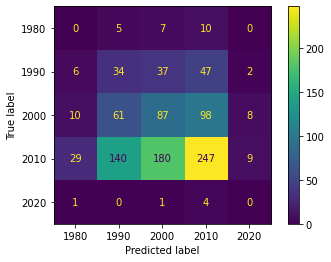

In [57]:
ConfusionMatrixDisplay.from_predictions(test_gen_2.classes, np.argmax(preds, axis=1), display_labels=list(test_gen_2.class_indices.keys()));